# FEE study

Study of performance of the "simple" FEE model of the PMT FE electronics

In [140]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib nbagg
%matplotlib inline

In [106]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
%autoreload 2

In [108]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

In [109]:
import system_of_units as units

In [110]:
import time

In [111]:
import FEE 

In [112]:
import tables

In [113]:
import mplFunctions as mpl
import wfmFunctions as wfm

In [217]:
import fit_library as fit

## Revised on:

In [114]:
print(time.strftime("%d/%m/%Y"))

30/10/2016


In [115]:
print(time.strftime("%H:%M:%S"))

10:50:07


In [103]:
!pep8 ../Sierpe/FEE.py

In [104]:
!pyflakes ../Sierpe/FEE.py

# Simple FEE model

The circuit in figure representss a simple model of the fron-end electronics of the energy plane (FEE). C2 is the  capacitor that decouples the PMT signal from DC. R1 is a large resistor to ground and Z1 is the equivalent impedance of the system. A high pass filter (HPF) originates from 1/(RC), where C = C2 and R:

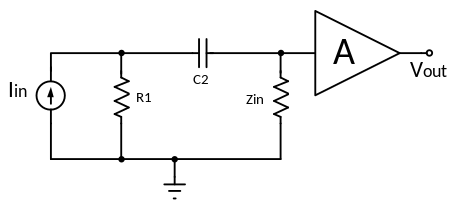

In [19]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "FEE_simple.png")

\begin{equation}
    R = R_1 + Z_{in}
\end{equation}

The amplifier is design to act as a low pass filter (LPF). It is modelled as the convolution of an order 1 LPF and an order 4 LPF.

The front end electronics is modelled by class SimpleFee, and the DAQ by class SimpleDAQ

### SimpleFee 

SimpleFee is a class (designed as a simple type, e.g, a data container) holding relevant information to describe the PMT front-end electronics, including the electronics gain, the value of capacitor C2, resistor R1 and impedance Zin (see above), and the values of the LPF associated to the shaping amplifier.

#### SimpleFee instance 

In [20]:
sfe = FEE.SimpleFee(gain=582.2*units.ohm, C2=8*units.nF, R1=1567*units.ohm, Zin=62*units.ohm, 
                 f_sample=1./(25*units.ns), f_LPF1=3E6*units.hertz, f_LPF2=10E6*units.hertz,
                 noise_rms=0.3*units.mV)

In [21]:
sfe


        (C2 =     8.0 nf, R1 =  1567.0 ohm, Zin =    62.0 ohm,
         gain =   582.2 ohm, f_sample =    40.0 MH,
         self.freq_HPF =   12.21 kHz, self.freq_LPF1 =    3.00 MHZ,
         self.freq_LPF2 =   10.00 MHZ,
         self.freq_HPFd =  0.00061  self.freq_LPF1d =    0.15
         self.freq_LPF2d =    0.50,
         noise_rms =    0.30 mV)
        

### SimpleDAQ

SimpleDAQ is a container class describing the data acquisition (for this simplified version it simply provides the conversion votsToADC)

#### SimpleDAQ instance

In [22]:
sdaq = FEE.SimpleDAQ( nbits=12)

In [23]:
sdaq


        (NIBTS = 12, LSB = 0.00049 volts/adc, volts to adc = 0.00039)
        

### SPE

Class SPE models a single photoelectron in the PMT (represents a delta by a narrow trapezoid)

#### SPE instance

In [24]:
spe = FEE.SPE(sfe)

In [25]:
spe


        (PMT gain = 4.5e+06, slope =  5.00 ns, flat =  1.00 ns)
        

### SPE functions

1. spe_pulse(spe,t0=100*units.ns, tmax=1e+6*units.ns, time_step=1*units.ns): generates a spe pulse between t0 and tmax in units of t_step
2. def spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus, time_step=1*units.ns): 
   generates a train of spe pulses between signal_start and (start+ length), in the window daq_window
   
3. spe_pulse_from_vector(spe,cnt): Returns a train of SPE pulses corresponding to vector cnt

<IPython.core.display.Javascript object>


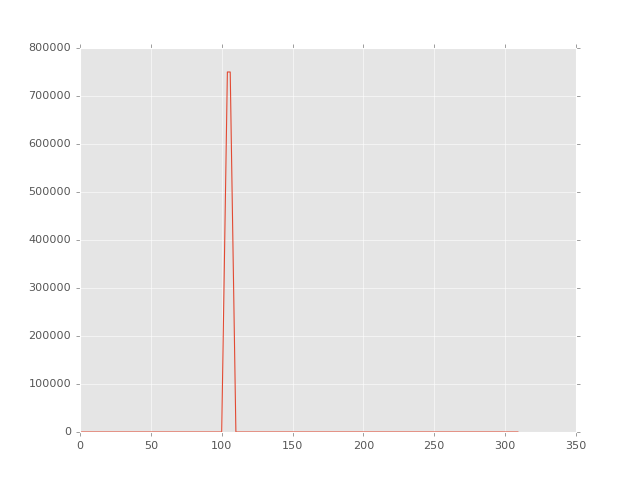

In [125]:
plt.plot(FEE.spe_pulse(spe,t0=100*units.ns, tmax=300*units.ns))

<IPython.core.display.Javascript object>


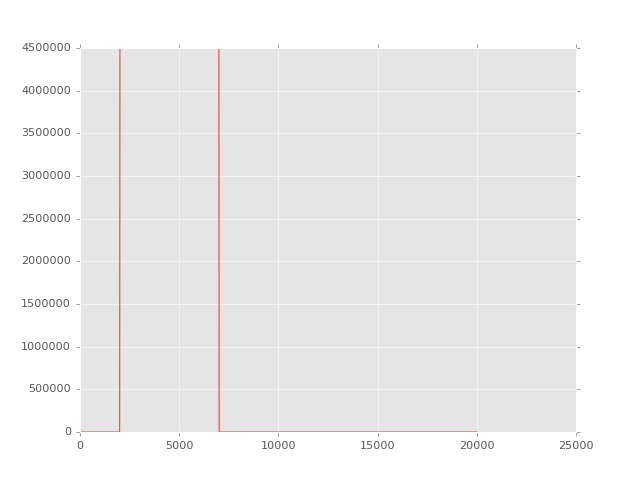

In [27]:
plt.plot(FEE.spe_pulse_train(spe,signal_start=2000*units.ns,signal_length=5000*units.ns, daq_window=20*units.mus))

In [28]:
cnt = np.random.poisson(5, 10000)

In [29]:
len(spe.spe)

11

<IPython.core.display.Javascript object>


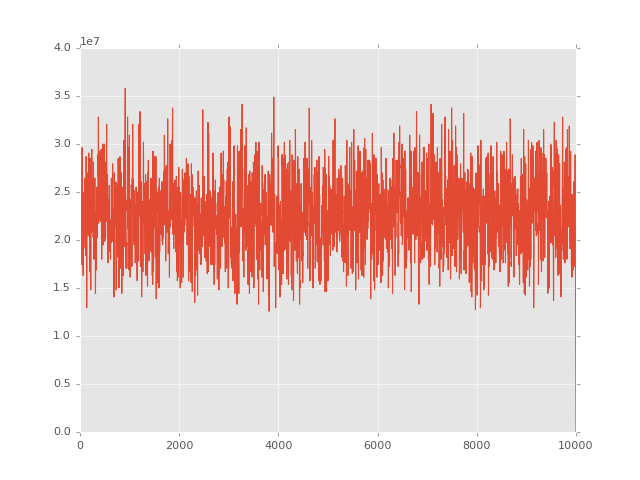

In [30]:
plt.plot(FEE.spe_pulse_from_vector(spe,cnt))

### FEE functions

1. i_to_adc(sfe,sdaq): conversion from current to adc counts
2. i_to_v(sfe): conversion from current to voltage
3. noise_adc(sfe,sdaq): noise outuput in adc counts

In [30]:
FEE.i_to_adc(sfe,sdaq)*100*units.muA

0.00014904319999999998

In [32]:
FEE.i_to_v(sfe)*units.muA/units.mV

0.5821999999999998

In [33]:
FEE.noise_adc(sfe, sdaq)

0.768

In [49]:
spe.pmt_gain

4500000.0

### Modeling FEE as the convolution of HPF and LPF filters

1. filter_fee(sfe): returns the parameter of the digital filter that represents the FEE electronics (.eg, the convolution of the HPF and the two LPD)
2. filter_fee_lpf(sfe): returns the parameters of the digital filter that represents an ideal electronic where deconvolution would be perfect (e.g, convolution of the LPF filters, not HPF). 
3. filter_fee_hpf(sfe): returns the parameters of the digital filter that represents only the HPF).

In [31]:
b,a = FEE.filter_fee(sfe)

In [32]:
print(a,b/units.ohm)

(array([ 1.        , -1.61088427,  1.09765517, -0.78293618,  0.31493283,
       -0.02845595,  0.01080426]), array([ 10.58277784,  42.33111137,  52.91388922,   0.        ,
       -52.91388922, -42.33111137, -10.58277784]))


In [33]:
def plot_filter(sfe):
    """
    plots the filter
    """
    b,a = FEE.filter_fee(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*sfe.f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(sfe.freq_HPFd, color='green') # cutoff frequency
    plt.show()

<IPython.core.display.Javascript object>


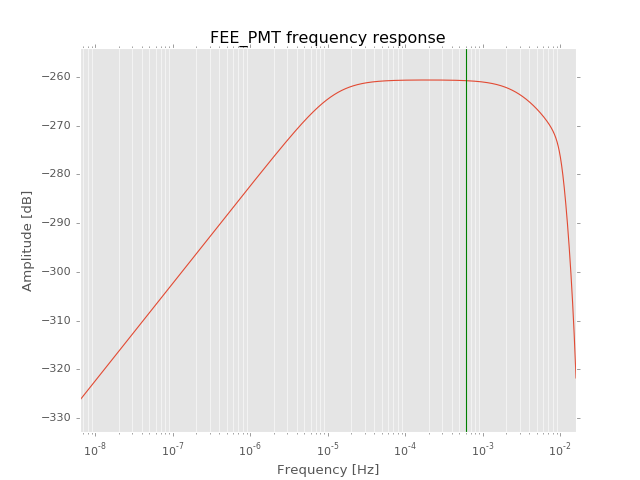

In [34]:
plot_filter(sfe)

In [35]:
def plot_filter_lpf(sfe):
    """
    plots the lpf filter
    """
    b,a = FEE.filter_fee_lpf(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*sfe.f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(sfe.freq_LPF1d, color='green') # cutoff frequency
    plt.show()

<IPython.core.display.Javascript object>


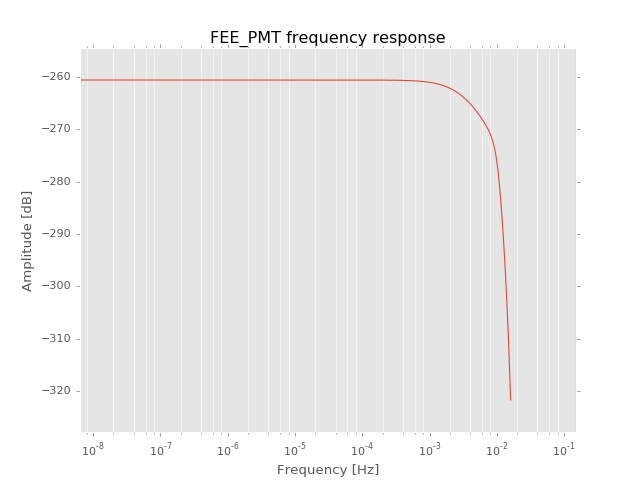

In [36]:
plot_filter_lpf(sfe)

In [37]:
def plot_filter_hpf(sfe):
    """
    plots the lpf filter
    """
    b,a = FEE.filter_fee_hpf(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*sfe.f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(sfe.freq_HPFd, color='green') # cutoff frequency
    plt.show()

<IPython.core.display.Javascript object>


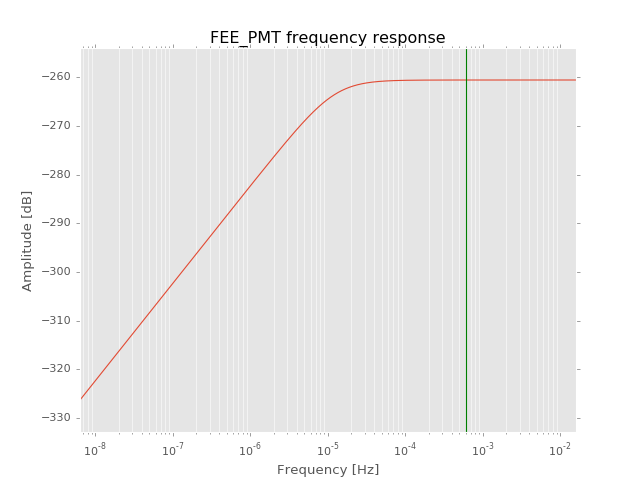

In [38]:
plot_filter_hpf(sfe)

### Effect of the FEE

1. signal_fee(sfe,signal_in): takes an instance of sfe and a signal and returns the output of the full FEE (convolution of HPF and LPF filters)
2. signal_fee_lpf(sfe,signal_in): Same, but the output is the effect of LPF filters only
3. signal_fee_hpf(sfe,signal_in): Same, but the output is the effect of HPF filters only


### Effect of FEE in a square signal

#### Generate a square signal as a train of SPE

In [39]:
signal_PE = FEE.spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus)

<IPython.core.display.Javascript object>


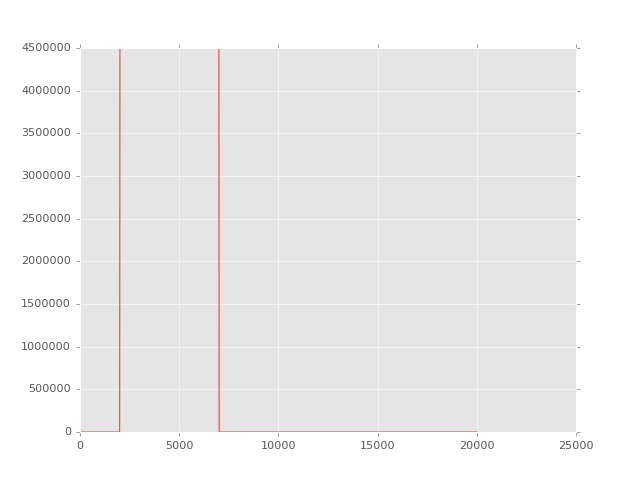

In [40]:
plt.plot(signal_PE)

#### Effect of the full FEE (LPF + HPF)

In [41]:
sgn_fee =FEE.signal_fee(sfe,signal_PE)

<IPython.core.display.Javascript object>


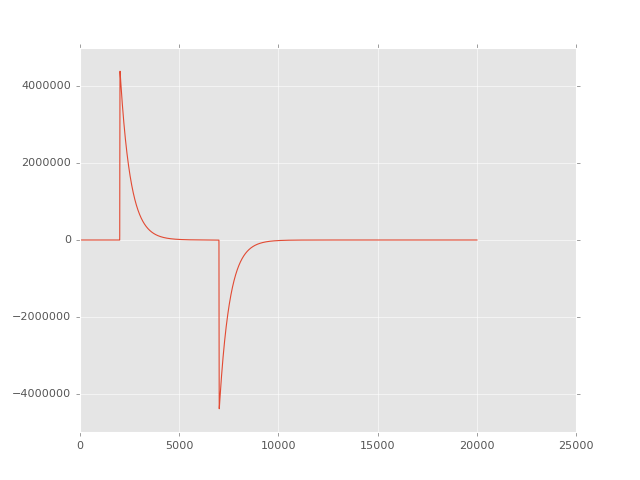

In [42]:
plt.plot(sgn_fee)

#### LPF

In [43]:
sgn_fee_lpf =FEE.signal_fee_lpf(sfe,signal_PE)

<IPython.core.display.Javascript object>


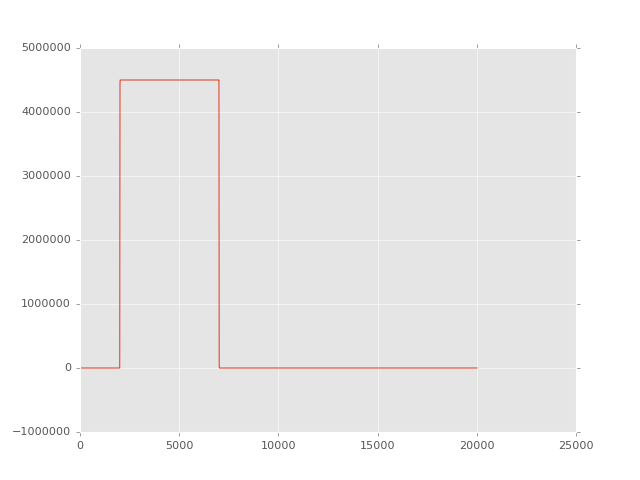

In [44]:
plt.plot(sgn_fee_lpf)

#### HPF

In [45]:
sgn_fee_hpf =FEE.signal_fee_hpf(sfe,signal_PE)

<IPython.core.display.Javascript object>


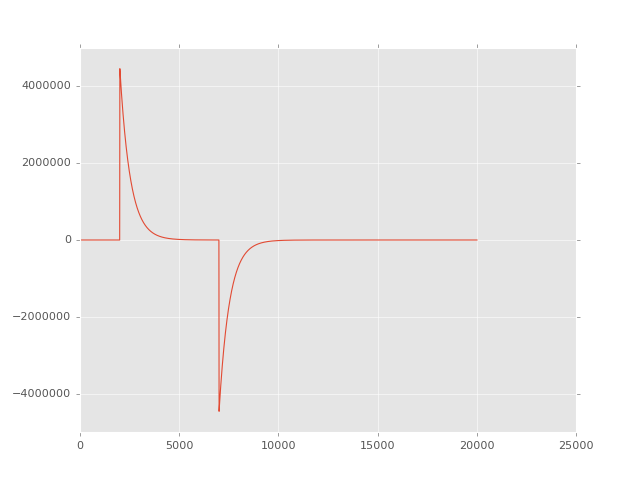

In [46]:
plt.plot(sgn_fee_hpf)

#### NB: the effect of the LPF appears negligible in a square signal. 

In [47]:
def signal_area_r2(signal_in, signal_filt):
    r_in_lpf = np.sum(signal_in)/np.sum(signal_filt)
    print('signal_in/signal_filt = {} '.format(r_in_lpf))

In [48]:
signal_area_r2(signal_PE, sgn_fee_lpf)

signal_in/signal_filt = 1.0 


In [49]:
signal_area_r2(signal_PE, sgn_fee_hpf)

signal_in/signal_filt = 6.5485001268e+11 


### Deconvolution algorithm

The simplest version of the deconvolution algorithm (no noise)

In [50]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [51]:
signal_r, acum = deconv_simple(sgn_fee,coef=sfe.freq_HPFd*np.pi)

<IPython.core.display.Javascript object>


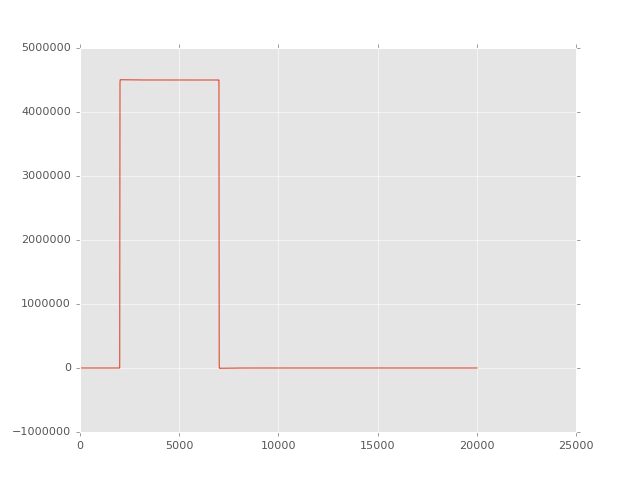

In [54]:
plt.plot(signal_r)

<IPython.core.display.Javascript object>


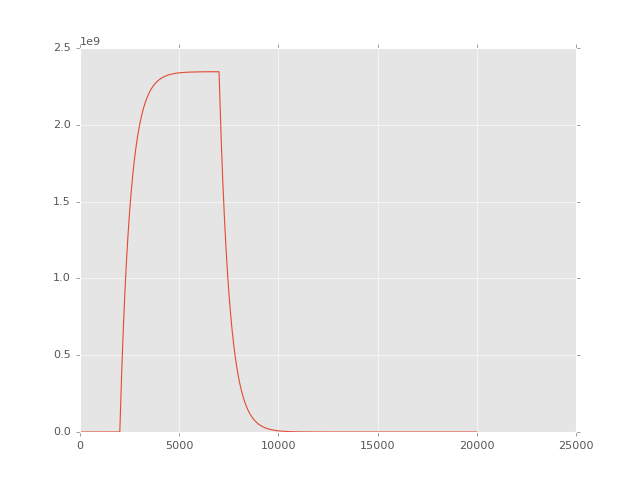

In [55]:
plt.plot(acum)

### Ideal case: perfect deconvolution

<IPython.core.display.Javascript object>


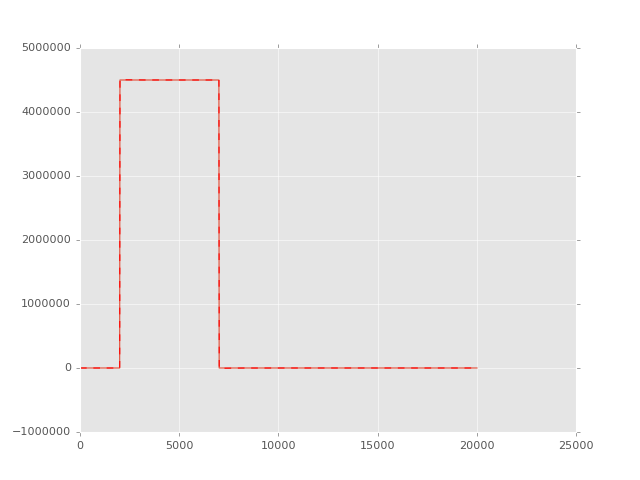

In [56]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_r)),signal_r,'r--', linewidth=1)
plt.show()

In [57]:
def signal_area_ratio(signal_in, signal_lpf, signal_r):
    r_in_lpf = np.sum(signal_in)/np.sum(signal_lpf)
    r_in_r = np.sum(signal_in)/np.sum(signal_r)
    print('signal_in/signal_lpf = {} signal_in/signal_r = {}'.format(r_in_lpf, r_in_r))

In [58]:
signal_area_ratio(signal_PE, sgn_fee_lpf, signal_r)

signal_in/signal_lpf = 1.0 signal_in/signal_r = 1.00000030667


### Convolution/Deconv for short signals

In [59]:
signal_PE = FEE.spe_pulse(spe,t0=100*units.ns, tmax=500*units.ns)

<IPython.core.display.Javascript object>


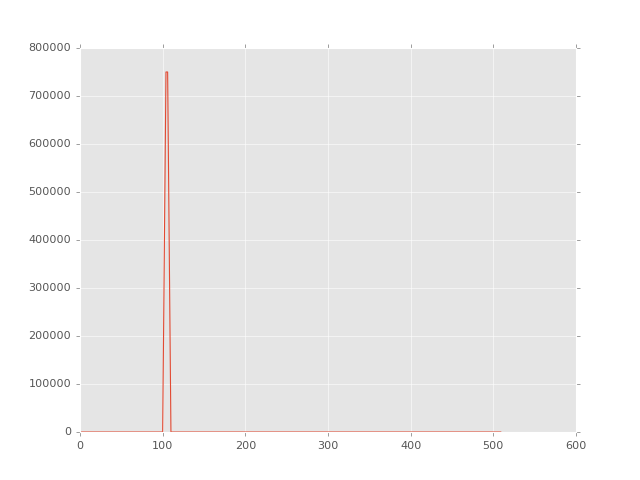

In [60]:
plt.plot(signal_PE)

In [61]:
sgn_fee_lpf = FEE.signal_fee_lpf(sfe,signal_PE)

In [62]:
sgn_fee = FEE.signal_fee(sfe,signal_PE)

<IPython.core.display.Javascript object>


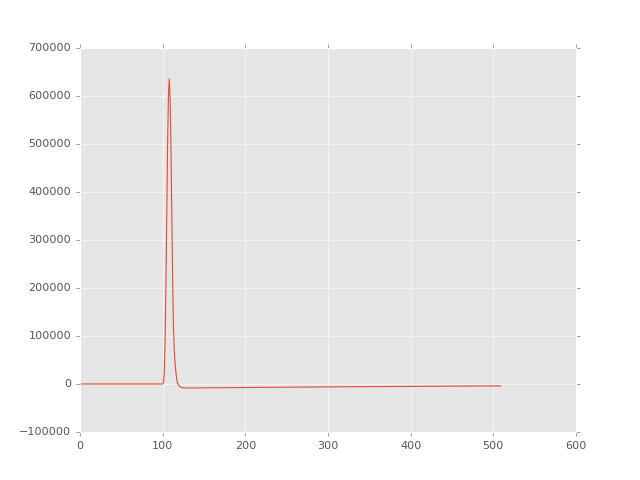

In [63]:
plt.plot(sgn_fee)

<IPython.core.display.Javascript object>


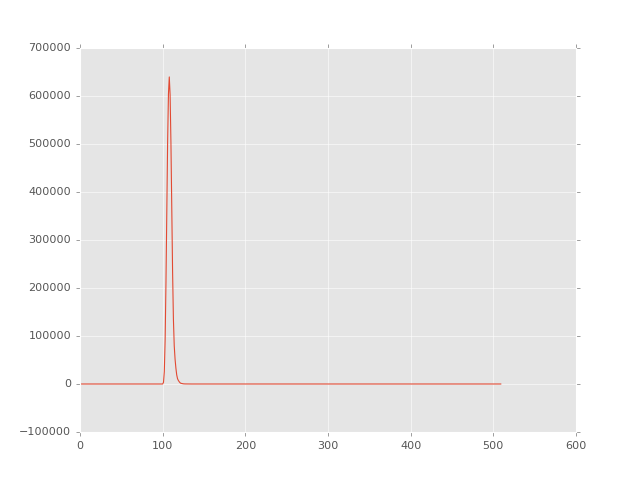

In [64]:
plt.plot(sgn_fee_lpf)

<IPython.core.display.Javascript object>


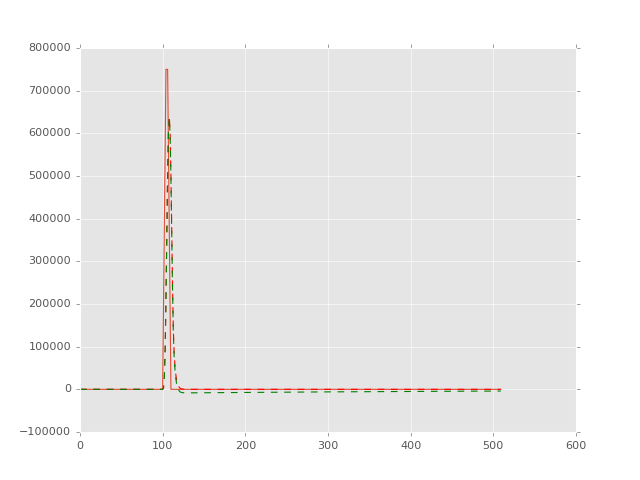

In [65]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_PE)),sgn_fee_lpf,'r--', linewidth=1)
plt.plot(np.arange(len(signal_PE)),sgn_fee,'g--', linewidth=1)
plt.show()

<IPython.core.display.Javascript object>


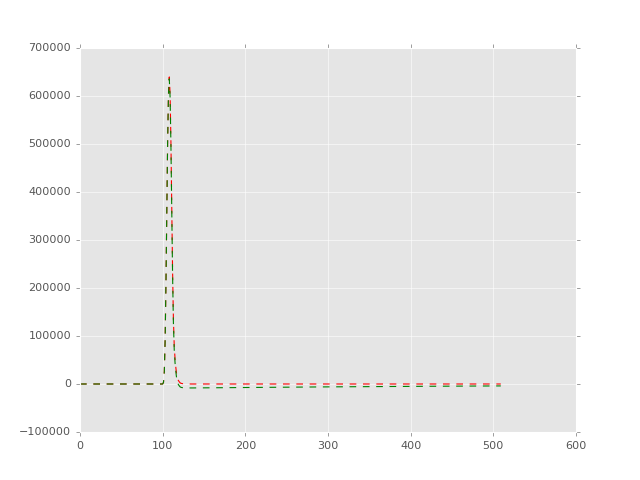

In [66]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),sgn_fee_lpf,'r--', linewidth=1)
plt.plot(np.arange(len(signal_PE)),sgn_fee,'g--', linewidth=1)
plt.show()

In [141]:
signal_area_ratio(signal_PE, sgn_fee_lpf, sgn_fee)

signal_in/signal_lpf = 1.0 signal_in/signal_r = 2.15859415681


#### Deconvolution

In [67]:
signal_r, acum = deconv_simple(sgn_fee,coef=sfe.freq_HPFd*np.pi)

<IPython.core.display.Javascript object>


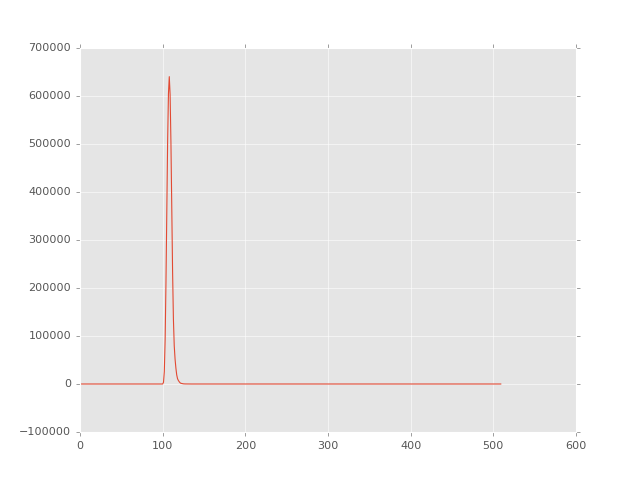

In [68]:
plt.plot(signal_r)

<IPython.core.display.Javascript object>


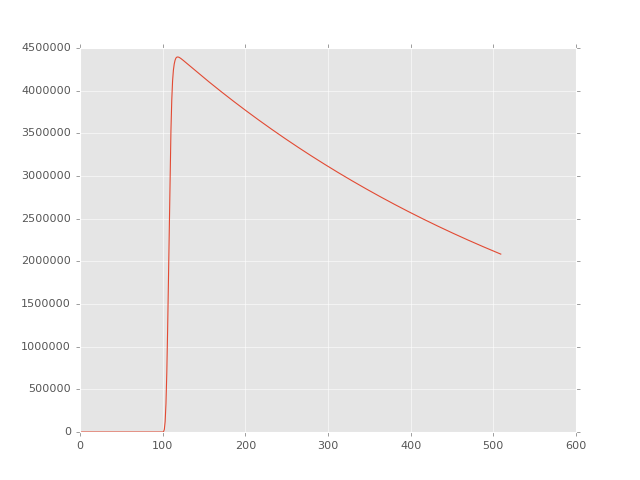

In [69]:
plt.plot(acum)

<IPython.core.display.Javascript object>


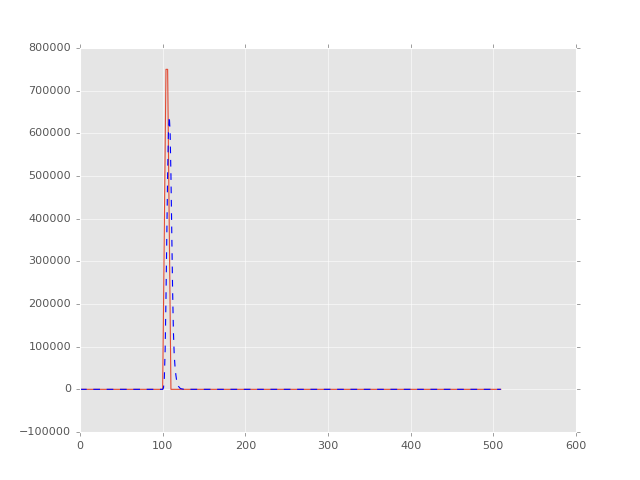

In [71]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_r)),signal_r,'b--', linewidth=1)
plt.show()

#### NB: the deconvolution algorithm deconvolves the HPF, but the effect of the LPF, which is invisible in long signals appears evident in the single photoelectron pulse.

In [72]:
signal_area_ratio(signal_PE, sgn_fee_lpf, signal_r)

signal_in/signal_lpf = 1.0 signal_in/signal_r = 0.999556008994


# Full FEE model

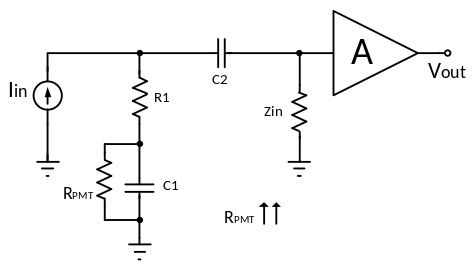

In [96]:
PATH = "./Rpar_Images/"; Image(filename = PATH + "FEE_PMT.png")

## ==== NOISE MODEL (PMT AND FEE are combined) ====

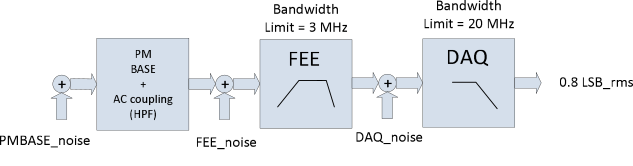

In [116]:
PATH = "./Rpar_Images/"; Image(filename = PATH + "NOISE.png")

$$ GAIN=FEE_{GAIN}.DAQ_{GAIN} $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = v_{DAQnoise}^{2}(out) + v_{FEE+PMBnoise}^{2}(out) $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = \int_{0}^{BW=3MHz}{v_{FEE+PMBnoise}^{2}.{\lvert}GAIN.H(jw){\rvert}^2}  + \int_{0}^{BW=20MHz}{v_{DAQnoise}^{2}.{\lvert}DAQ_{GAIN}.H(jw){\rvert}^2} $$
$$ $$
$$ vo_{TOTAL_{noise(rms)}} = \sqrt{vo_{TOTAL_{noise}}^{2}} = 0.76LSB_{rms}$$

### MEASURED NOISE 
$$ v_{DAQnoise}^{2}(out) = 0.64 LSB_{rms} = 0.3136 mV_{rms} $$
$$ v_{FEE+PMBnoise}^{2}(out) = 0.41 LSB_{rms} = 0.2009 mV_{rms} $$

In [117]:
MEASURED_GAIN = 582.237
DAQ_GAIN = 1.25
SPE = 20
print "SPE (iLSB_ADC)= ", SPE



SPE (iLSB_ADC)=  20


In [118]:
feep = FEE.FeePmt(gain=MEASURED_GAIN*units.ohm, C2=8*units.nF, C1=2714*units.nF,
                  R1=1567*units.ohm, Zin=62*units.ohm, 
                  f_sample=1./(25*units.ns), f_LPF1=3*units.MHZ, 
                  f_LPF2=10*units.MHZ,
                  noise_FEEPMB_rms=0*units.mA)



In [119]:
LSB_DAQ = 2.0/(2**12); print "LSB_DAQ = ",LSB_DAQ
feep

LSB_DAQ =  0.00048828125



        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         self.freq_LHPF =   12.25 kHz,
         self.freq_LPF1 =    3.00 MHZ,
         self.freq_LPF2 =   10.00 MHZ,
         self.freq_LHPFd =  0.00061,
         self.freq_LPF1d =    0.15,
         self.freq_LPF2d =    0.50,
         self.noise_FEEPMB_rms =    0.00 mA,
         self.LSB =    0.39 mV)
        

In [120]:
b,a = FEE.filter_feepmt(feep); b = b/units.ohm

In [121]:
print('filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

filter parameters: a = [ 1.         -1.61087863  1.09765171 -0.78293344  0.31493115 -0.02845585
  0.0108042 ] b = [  6.60566806e+16   2.64227111e+17   3.30285344e+17   3.88308388e+12
  -3.30279520e+17  -2.64224781e+17  -6.60562923e+16] ohm


f_sample= 40.0


<IPython.core.display.Javascript object>


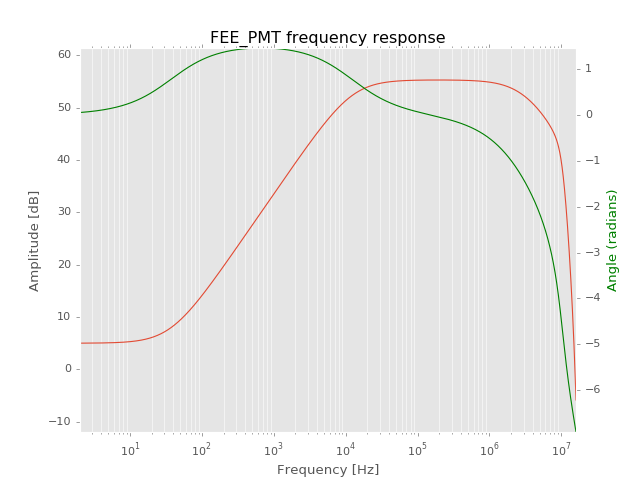

In [126]:
print "f_sample=",feep.f_sample/units.MHZ
w, h = signal.freqz(b, a, worN=np.logspace(-6.5,0.4,40000))                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
fig = plt.figure(2)
ax1 = fig.add_subplot(111)
plt.semilogx(w*(feep.f_sample/units.hertz)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('FEE_PMT frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.semilogx(w*(feep.f_sample/units.hertz)/(2*np.pi), angles,'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')

plt.show()

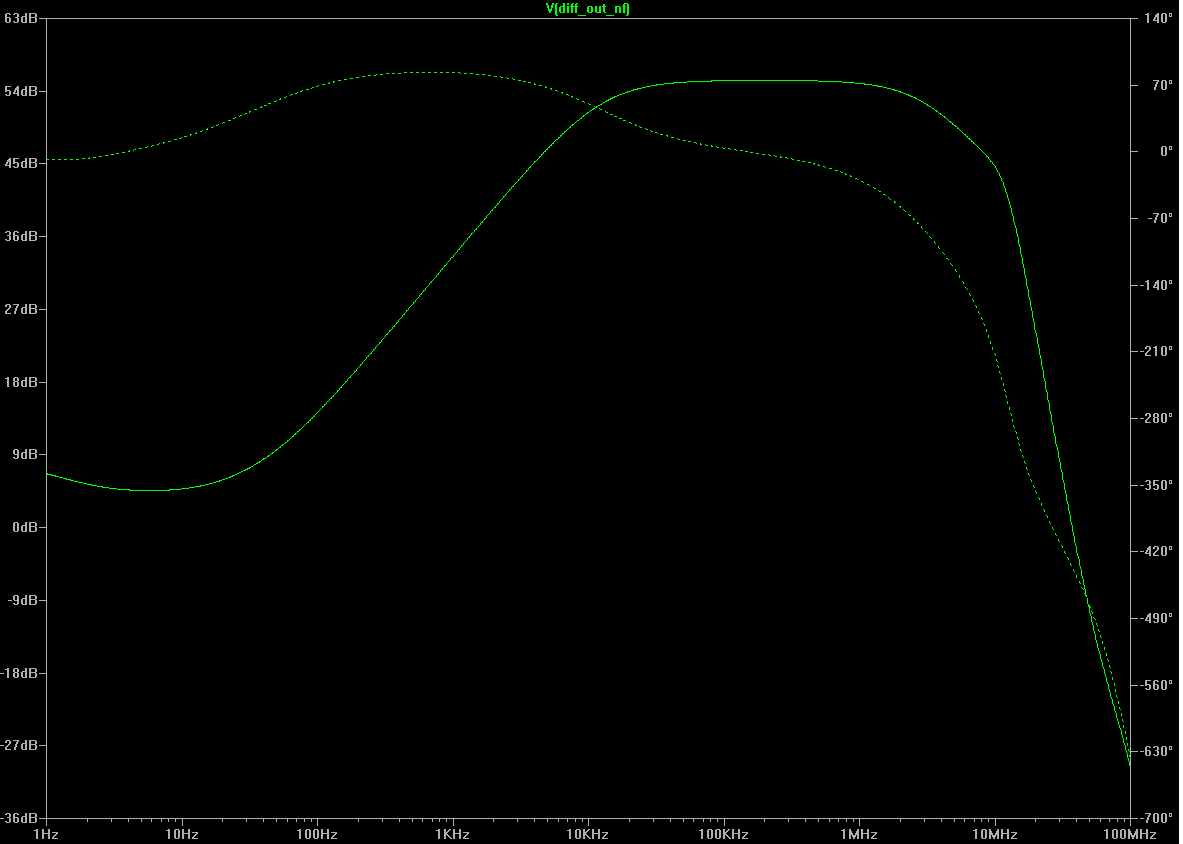

In [123]:
Image(filename = PATH + "FEE_PMT_freq_response_simulated_spice.png")

#### MATCH!!!   --VERY CLOSE TO THE SPICE SIMULATED ONE--

### =======   TEST WITHOUT NOISE   ========

In [127]:
signal_in = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA
#signal_out = signal.lfilter(b,a,signal_in[0,0:])
signal_out = FEE.signal_feepmt(feep,signal_in)

<IPython.core.display.Javascript object>


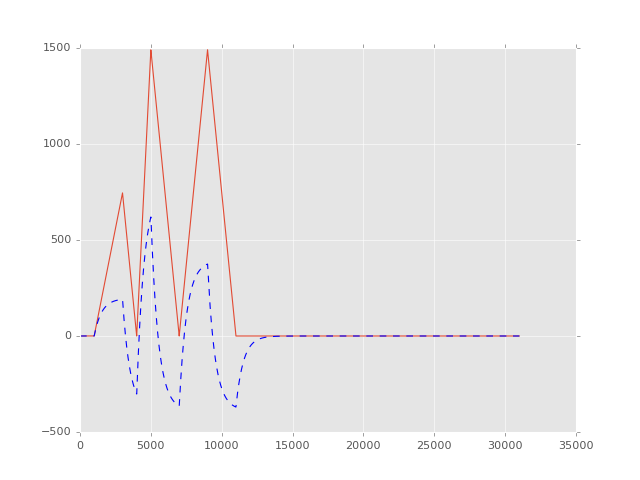

In [129]:
plt.figure(1)
plt.plot(range(0,np.size(signal_in),1),signal_in*feep.GAIN/feep.LSB)
plt.plot(range(0,np.size(signal_in),1),signal_out/feep.LSB,'b--', linewidth=1)
plt.show()

In [ ]:
signal_r=BLRc(signal_daq=signal_out/units.volt,coef=feep.freq_LHPFd*np.pi,thr=0.75*feep.LSB/units.volt)



In [151]:
signal_r, acum = deconv_simple(signal_out/units.volt,coef=feep.freq_LHPFd*np.pi)

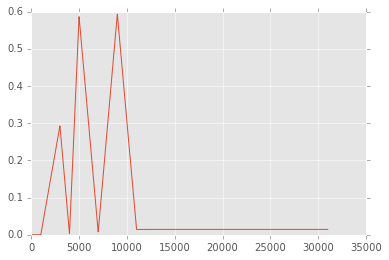

In [152]:
plt.plot(signal_r)

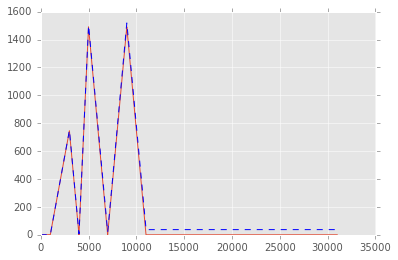

In [153]:
plt.figure(3)
plt.plot(range(0,np.size(signal_in),1),signal_in*feep.GAIN/feep.LSB)  # adc
plt.plot(range(0,np.size(signal_r),1),signal_r/(feep.LSB/units.volt),'b--', linewidth=1) #adc
plt.show()

In [159]:
energy_mea=np.sum(signal_r[1000:11000]/(feep.LSB/units.volt))
energy_in=np.sum((signal_in*feep.GAIN)/units.volt/(feep.LSB/units.volt))
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 6334738.56
Reconstructed Energy = 6499097.56906
Error in Energy Computation (%) = -2.5945665713


## DECONVOLUTION USING CLEANING FILTER + BLR

In [160]:
b_cf, a_cf = FEE.filter_cleaner(feep)

### (b_cf / a_cf) ARE THE COEFFICIENTS OF THE CLEANING FILTER

In [161]:
signal_out_cf = signal.lfilter(b_cf,a_cf,signal_out/units.volt)*units.volt

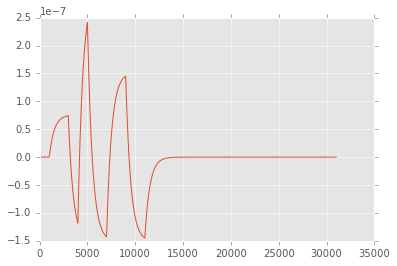

In [162]:
plt.plot(signal_out_cf)

In [163]:
signal_out_cf2 = signal.lfilter(b_cf,a_cf,signal_out)

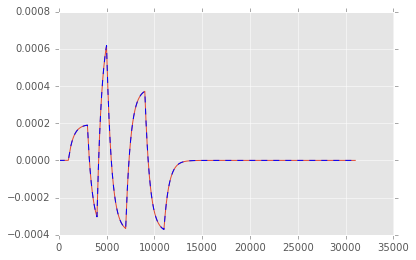

In [166]:
plt.figure(4)
plt.plot(range(0,np.size(signal_out_cf),1),signal_out_cf/(feep.LSB/units.volt))  # adc
plt.plot(range(0,np.size(signal_out_cf2),1),signal_out_cf2/(feep.LSB/units.volt),'b--', linewidth=1) #adc
plt.show()

In [168]:
signal_r2, acum = deconv_simple(signal_out_cf/units.volt,coef=feep.freq_LHPFd*np.pi)

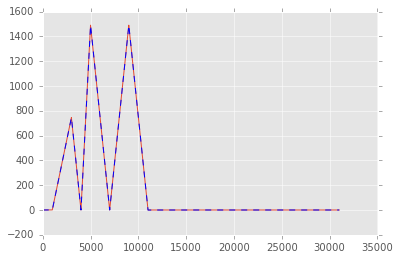

In [171]:
plt.figure(5)
plt.plot(range(0,np.size(signal_in),1),signal_in*feep.GAIN/feep.LSB)
plt.plot(range(0,np.size(signal_r2),1),signal_r2/(feep.LSB/units.volt),'b--', linewidth=1)
plt.show()

In [176]:
energy_mea2=np.sum(signal_r2[1000:11000]/(feep.LSB/units.volt))
energy_in2=np.sum(signal_in*feep.GAIN/feep.LSB)
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6334918.78314
Error in Energy Computation (%) = -0.00284499725278


## ======  TEST WITH NOISE and DAQ EFFECT ======= 

In [181]:
MEASURED_GAIN = 582.237*units.ohm
DAQ_GAIN = 1.25

DAQn  = FEE.FeeDAQ(nbits=12, DAQnoise_rms=0.313*units.mV)
DAQn


        (NIBTS = 12, LSB = 0.00049 volts/adc,
        volts to adc = 0.00039,
         noise =    0.31)
        

In [184]:
DAQn.LSB/units.mV

0.48828124999999994

In [185]:
1*DAQn.LSB/(MEASURED_GAIN*DAQ_GAIN)/units.muA

0.6709037728622538

### NB: 

#### The Equivalent Input Noise must match the noise measured at the output. (1LSB related to output works fine)

#### THIS IS OF MAIN importance!!! If the noise is added afterwards the bandwidth is not limited and the LF noise effect do not appear in the BLR.

#### Remember that the bandwidth limited noise looks like a AM modulation with a LF frequency component which affects the BLR

In [187]:
feepN = FEE.FeePmt(gain=MEASURED_GAIN, C2=8*units.nF, C1=2714*units.nF,
                  R1=1567*units.ohm, Zin=62*units.ohm, 
                  f_sample=1./(25*units.ns), f_LPF1=3*units.MHZ, 
                  f_LPF2=10*units.MHZ,
                  noise_FEEPMB_rms=1*DAQn.LSB/(MEASURED_GAIN*DAQ_GAIN))
feepN


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         self.freq_LHPF =   12.25 kHz,
         self.freq_LPF1 =    3.00 MHZ,
         self.freq_LPF2 =   10.00 MHZ,
         self.freq_LHPFd =  0.00061,
         self.freq_LPF1d =    0.15,
         self.freq_LPF2d =    0.50,
         self.noise_FEEPMB_rms =    0.67 muA,
         self.LSB =    0.39 mV)
        

In [192]:
signal_in = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

In [193]:
signal_outn = FEE.signal_feepmt(feepN,signal_in)*DAQ_GAIN

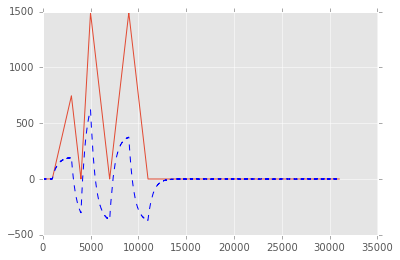

TRUE Out Noise FEE (LSB_rms) = 0.397953507325


In [195]:
plt.figure(5)
# notice units: signal_in [A] x GAIN (A/V) -->V
# signal_in [A] x GAIN / DAQn.LSB (V/V) ---> ADC counts
plt.plot(range(0,np.size(signal_in),1),DAQ_GAIN*signal_in*feep.GAIN/DAQn.LSB)
plt.plot(range(0,np.size(signal_outn),1),signal_outn/DAQn.LSB,'b--', linewidth=1)

plt.show()
print "TRUE Out Noise FEE (LSB_rms) =",np.std(signal_outn[25000:26000]/DAQn.LSB,ddof=1)

#### So the FEE output noise contribution matches with measurements

### Now add the DAQ contribution

In [196]:
signal_outnd = FEE.noise_adc(DAQn, signal_outn)

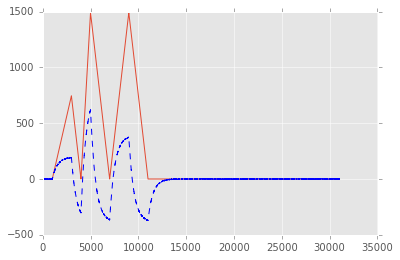

TRUE TOTAL Out Noise (LSB_rms) = 0.719780442829


In [197]:
plt.figure(6)
plt.plot(range(0,np.size(signal_in),1),DAQ_GAIN*signal_in*feep.GAIN/DAQn.LSB)
plt.plot(range(0,np.size(signal_outnd),1),signal_outnd/DAQn.LSB,'b--', linewidth=1)

plt.show()
print "TRUE TOTAL Out Noise (LSB_rms) =",np.std(signal_outnd[25000:26000]/DAQn.LSB,ddof=1)

## Reconstruct with Cleaning Filter

In [199]:
b_cf, a_cf = FEE.filter_cleaner(feepN)
signal_out_cf2 = signal.lfilter(b_cf,a_cf,signal_outnd)

In [202]:
signal_r3, acum = deconv_simple(signal_out_cf2,coef=feep.freq_LHPFd*np.pi)

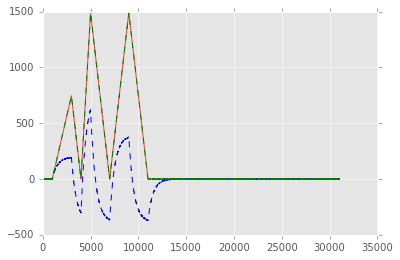

In [203]:
plt.figure(7)
plt.plot(range(0,np.size(signal_in),1),DAQ_GAIN*signal_in*feep.GAIN/DAQn.LSB)
plt.plot(range(0,np.size(signal_outnd),1),signal_outnd/DAQn.LSB,'b--', linewidth=1)
plt.plot(range(0,np.size(signal_r3),1),signal_r3/DAQn.LSB,'g--', linewidth=1)
plt.show()

In [204]:
energy_mea3=np.sum(signal_r3[1000:11000]/DAQn.LSB)
energy_in3=np.sum(signal_in*feep.GAIN*DAQ_GAIN/DAQn.LSB)
print 'Input Energy =', energy_in3
print 'Reconstructed Energy =', energy_mea3
print 'Error in Energy Computation (%) = ',(energy_in3-energy_mea3)/energy_in3*100

Input Energy = 6334738.56
Reconstructed Energy = 6333960.45807
Error in Energy Computation (%) =  0.0122830945629


## Statistics

In [214]:
MEASURED_GAIN = 582.237*units.ohm
DAQ_GAIN = 1.25
DAQn  = FEE.FeeDAQ(nbits=12, DAQnoise_rms=0.313*units.mV)

feepN = FEE.FeePmt(gain=MEASURED_GAIN, C2=8*units.nF, C1=2714*units.nF,
                  R1=1567*units.ohm, Zin=62*units.ohm, 
                  f_sample=1./(25*units.ns), f_LPF1=3*units.MHZ, 
                  f_LPF2=10*units.MHZ,
                  noise_FEEPMB_rms=1*DAQn.LSB/(MEASURED_GAIN*DAQ_GAIN))


signal_in = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

recons_a = np.zeros(1000)
for i in range(0,1000):
    signal_outn = FEE.signal_feepmt(feepN,signal_in)*DAQ_GAIN
    signal_outnd = FEE.noise_adc(DAQn, signal_outn)
    b_cf, a_cf = FEE.filter_cleaner(feepN)
    signal_out_cf2 = signal.lfilter(b_cf,a_cf,signal_outnd)
    signal_r3, acum = deconv_simple(signal_out_cf2,coef=feep.freq_LHPFd*np.pi)
    recons_a[i]=np.sum(signal_r3[1000:11000]/DAQn.LSB)

In [215]:
len(recons_a)

1000

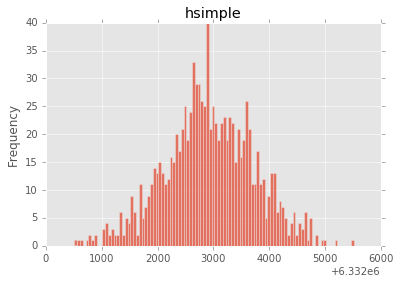

In [216]:
mpl.histo(recons_a,100)

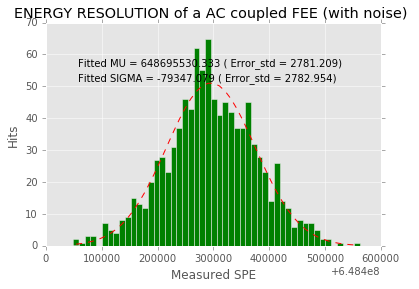

('Fitted A = ', 51.082547403423966, '( Error_std=', 1.5508264339130657, ')')
('Fitted MU = ', 648695530.33256829, '( Error_std=', 2781.2093098005785, ')')
('FItted SIGMA = ', -79347.079159349843, '( Error_std=', 2782.95430264366, ')')
ENERGY RESOLUTION (%) =  -0.0287447080033


In [218]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,8,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

## Reading  signals

#### List the files

In [73]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5


#### Open and inspect file

In [74]:
h5f = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_10000.root.h5','r+')

In [75]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_10000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 800), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(4898,), zlib(4)) ''
  

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [76]:
pmtrd = h5f.root.pmtrd

#### Plot pmtrd for the first event, first PMT

<IPython.core.display.Javascript object>


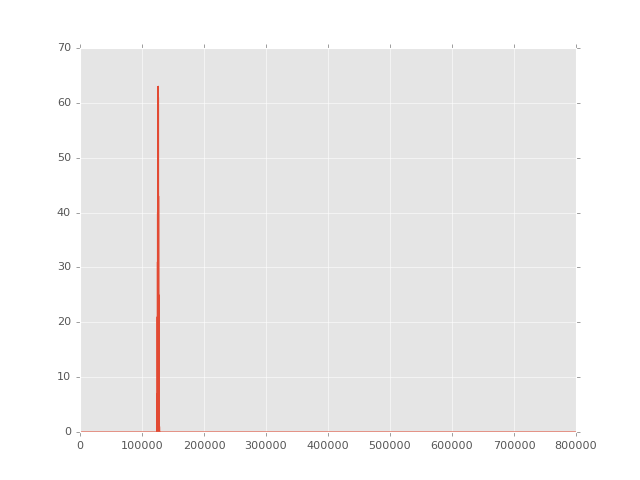

In [77]:
plt.plot(pmtrd[0,0])

<IPython.core.display.Javascript object>


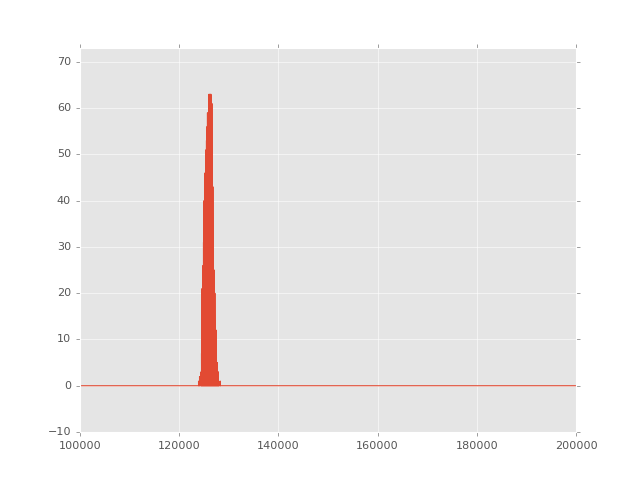

In [78]:
mpl.plts(pmtrd[0,0], signal_start=100000, signal_end=200000, offset=10)

### Convolve with the FEE

In [79]:
pmtrwf = FEE.signal_fee(sfe,pmtrd[0,0])

<IPython.core.display.Javascript object>


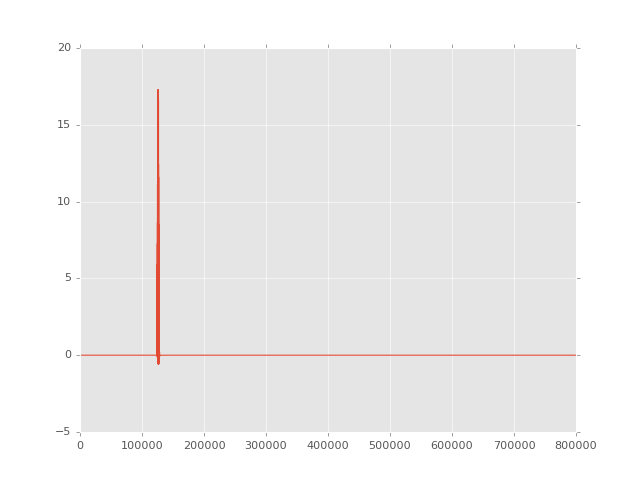

In [80]:
plt.plot(pmtrwf)

<IPython.core.display.Javascript object>


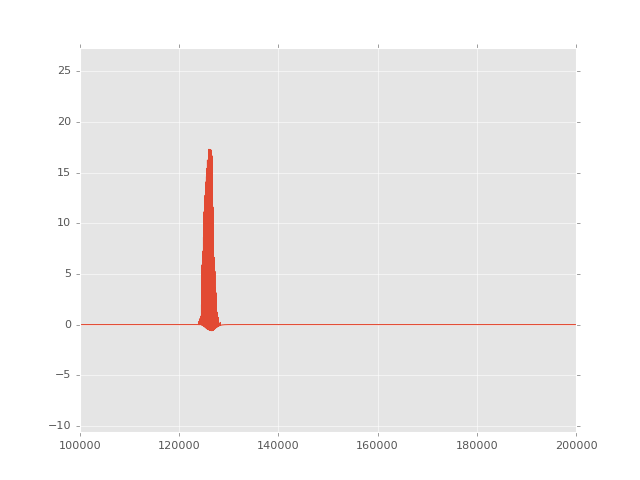

In [81]:
mpl.plts(pmtrwf, signal_start=100000, signal_end=200000, offset=10)

#### NB: With the new parameters the effect of the electronics in the short kripton signals appears small!

### Talium source

In [82]:
h5f_tl = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_10000.root.h5','r+')

In [83]:
pmtrd = h5f_tl.root.pmtrd

<IPython.core.display.Javascript object>


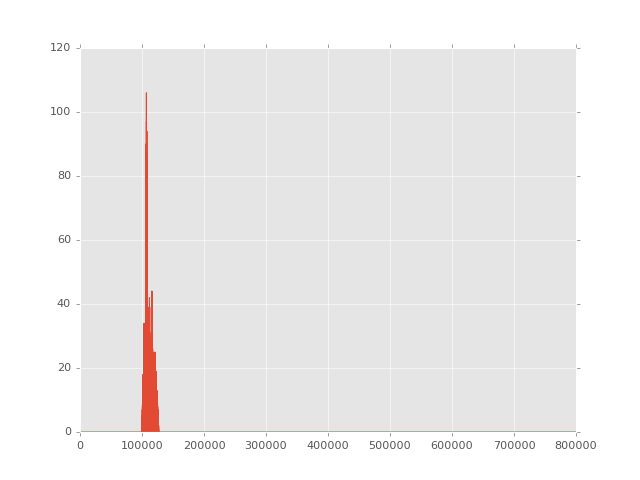

In [85]:
plt.plot(pmtrd[0,0])

<IPython.core.display.Javascript object>


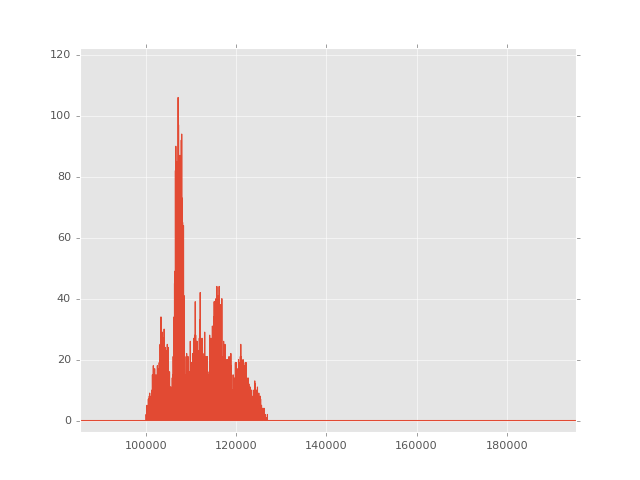

In [87]:
mpl.plts(pmtrd[0,0], signal_start=90000, signal_end=200000, offset=10)

In [88]:
pmtrwf = FEE.signal_fee(sfe,pmtrd[0,0])

<IPython.core.display.Javascript object>


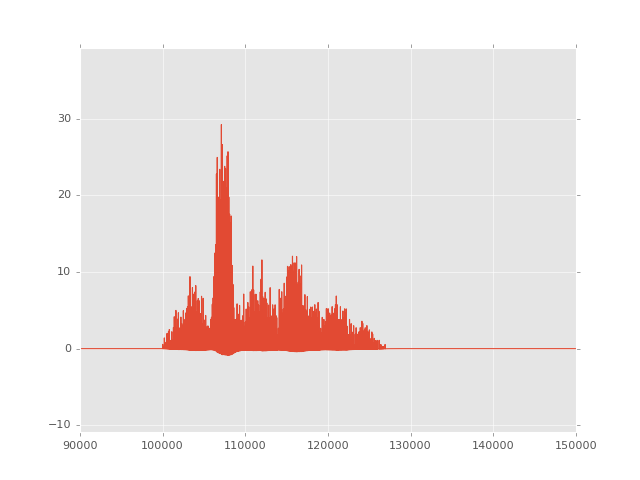

In [91]:
mpl.plts(pmtrwf, signal_start=90000, signal_end=150000, offset=10)

In [ ]:
def filter_cleaner(feep):
    """
    cleans the signal(VHB to document)
    """
    freq_zero=1/((feep.R1/units.ohm)*(feep.C1/units.farad));
    #print ('Zero(Hz) =',freq_zero/(2*np.pi));
    freq_zerod= freq_zero / ((feep.f_sample/units.hertz)*np.pi);
    #print ('Zero(rad/sec) =',freq_zero,'// (half-cycles/sample) =',freq_zerod)

    b, a = signal.butter(1, freq_zerod, 'high', analog=False);

    return b, a

In [94]:
R1 = 10*units.ohm
C1 = 5*units.farad
fz = 1./((R1/units.ohm)*(C1/units.farad))
fs = 100*np.pi/units.hertz
print(fz/fs)
f2z = 1./(R1*C1)
f2s = 100*np.pi
print(f2z/f2s)

6.36619772368e-14
6.36619772368e-14
